In [20]:
import json
import pandas as pd
import numpy as np
import csv

%matplotlib inline

In [2]:
# This is my implementation of a finetuned VGG16

from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [26]:
# Rely on the pre-written util library from the course to do plots
from utils import plots, save_array, load_array

In [4]:
FILES_PATH = 'http://files.fast.ai/models'
CLASS_FILE = 'imagenet_class_index.json'

fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')

with open(fpath) as f:
    class_dict = json.load(f)

classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [5]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

In [6]:
# Define the convolution block for VGG
def convBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [7]:
# Define the fully connected block for VGG
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [8]:
# Mean normalization of RGB channels, also reversed into BGR order
# This was provided by the VGG researchers

def vgg_preprocess(x):
    
    vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

    x = x - vgg_mean
    return x[:, ::-1]

In [11]:
# Getting the full model:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224), 
                     output_shape=(3, 224,224)))
    
    convBlock(2, model, 64)
    convBlock(2, model, 128)
    convBlock(3, model, 256)
    convBlock(3, model, 512)
    convBlock(3, model, 512)
    
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(1000, activation='softmax'))
    
    return model

In [12]:
model = VGG_16()

In [13]:
fpath = get_file('vgg16.h5', FILES_PATH + 'vgg16.h5', cache_subdir='models')

In [14]:
model.load_weights(fpath)

In [15]:
batch_size = 64

In [16]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True,
               batch_size=batch_size, class_mode='categorical'):
    
    return gen.flow_from_directory(path + dirname, target_size=(224, 224),
                                   class_mode=class_mode, shuffle=shuffle,
                                   batch_size=batch_size)

In [17]:
path = "../data/dogscats/"
# path = "../data/dogscats/sample/"

In [18]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)

imgs, labels = next(batches)

Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.


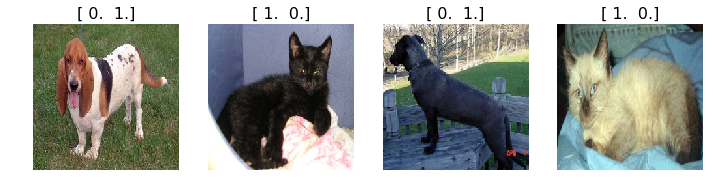

In [21]:
plots(imgs[:4], titles=labels[:4])

In [22]:
# Now we have the VGG Model created from scratch (with loaded weights)
# So below we add the fine tuning code.

def finetune(model, batches):
    # Remove the top layer
    model.pop()
    # Freeze the rest of the layers
    for layer in model.layers:
        layer.trainable=False
    
    # Add a new final layer with the right number of classes
    model.add(Dense(batches.nb_class, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    # Write our classes out
    classes = list(iter(batches.class_indices))
    for c in batches.class_indices:
        classes[batches.class_indices[c]] = c
    
    return model, classes

In [23]:
model, classes = finetune(model, batches)

In [24]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, 
                    nb_epoch=3, validation_data=val_batches,
                   nb_val_samples=val_batches.nb_sample)

Epoch 1/3
22778/22778 [==============================] - 643s - loss: 0.1150 - acc: 0.9680 - val_loss: 0.0496 - val_acc: 0.9833

In [25]:
model.save_weights('catsdogsweights.h5')

In [27]:
test_batch_size = batch_size * 2

In [28]:
gen = image.ImageDataGenerator()
test_batches = gen.flow_from_directory('../data/dogscats/test', 
                                       batch_size=test_batch_size, 
                                       shuffle=False,
                                       class_mode=None,
                                       target_size=(224,224))

Found 12500 images belonging to 1 classes.


In [ ]:
# # Now lets define our batch predict

# def pred_batch_generator(model, batches, write=False):
    
#     preds = model.predict_generator(batches, batches.nb_sample)
#     idxs = np.argmax(preds, axis=1)
    
#     for i in range(len(idxs)):
#         idx = idxs[i]
        
#         if not write:
#             print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))
#         else:
#             with open('catsdogs_prediction_v3.csv', 'a') as csvf:
#                 writer = csv.writer(csvf, delimiter=',', 
#                                     quotechar='"',
#                                     quoting=csv.QUOTE_MINIMAL)
                
#                 writer.writerow([i, preds[i, idx]])

In [29]:
preds = model.predict_generator(test_batches, test_batches.nb_sample)

In [31]:
print preds[:5]
print test_batches.filenames[:5]

[[  1.0000e+00   2.9196e-13]
 [  6.7566e-01   3.2434e-01]
 [  1.0000e+00   3.7631e-08]
 [  1.0000e+00   1.2056e-14]
 [  2.5417e-11   1.0000e+00]]
['test/9292.jpg', 'test/12026.jpg', 'test/9688.jpg', 'test/4392.jpg', 'test/779.jpg']


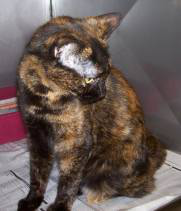

In [33]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(path + '/test/' + test_batches.filenames[2])

In [ ]:
df = pd.read_csv('catsdogs_prediction.csv')

In [ ]:
df['id'] = df['id'] + 1

In [ ]:
df['label'] = df['label'].apply(lambda x: max(min(0.95, x), 0.05))

In [ ]:
df

In [ ]:
df.to_csv('catsdogs_prediction.csv', index=False)

In [ ]:
df_rdx = pd.read_csv('../data/redux/redux_submit.csv')

In [ ]:
df_rdx.sort_values('id')